In [30]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [31]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\afrah
[nltk_data]     khan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Data Preprocessing

In [67]:
df=pd.read_csv(r"C:\Users\afrah khan\Downloads\supportTicketData.csv")

In [68]:
df.sample(5)

,TicketID,Ticket detailed description,urgency-Priority
13739,137195,patch cords connect by wire hi please informed...,P3
7491,130947,sent friday personal expense dinner hi can you...,P1
8157,131613,sent wednesday march re issues with ad hi cann...,P1
1630,125086,line manager change dears please rise ticket c...,P1
2389,125845,upgrade analyst ext sent tuesday october re up...,P1


In [69]:
df.columns = ['TicketID', 'Description', 'Priority']

In [70]:
print("Priority Distribution:\n", df['Priority'].value_counts())

Priority Distribution:
 Priority
P3    7520
P1    6748
P2    5528
Name: count, dtype: int64


# EDA

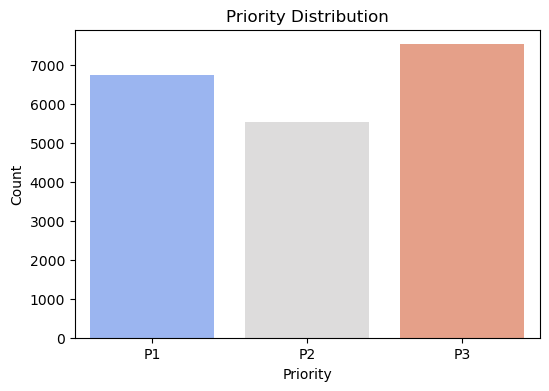

In [71]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Priority'], palette='coolwarm')
plt.title("Priority Distribution")
plt.xlabel("Priority")
plt.ylabel("Count")
plt.show()

In [72]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


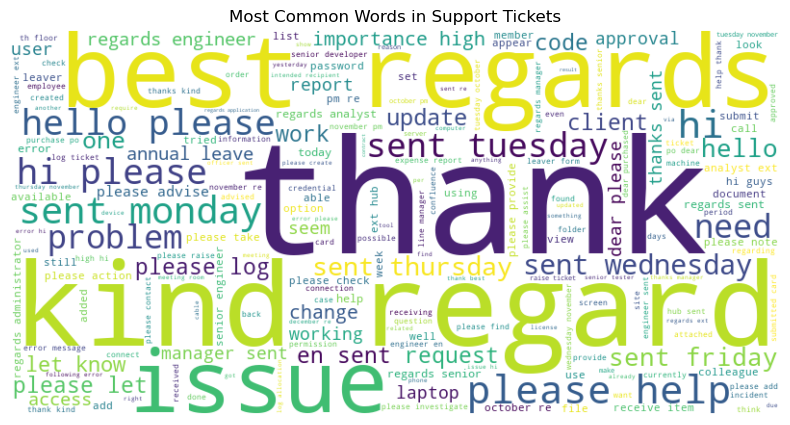

In [73]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Description']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Support Tickets")
plt.show()

C:\Users\afrah khan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


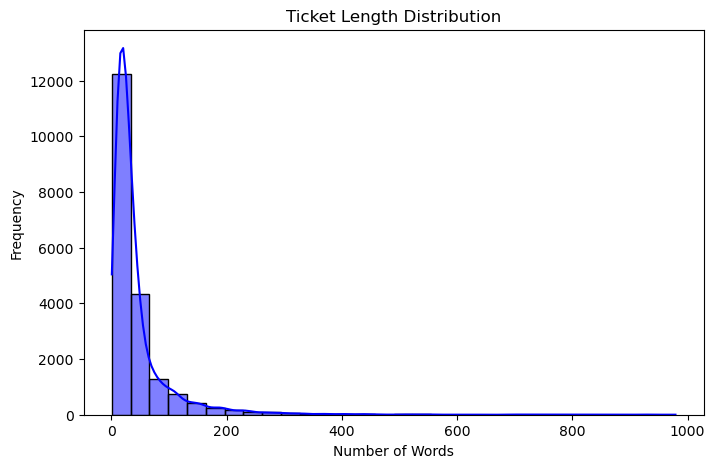

In [74]:
df['Text_Length'] = df['Description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['Text_Length'], bins=30, kde=True, color='blue')
plt.title("Ticket Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

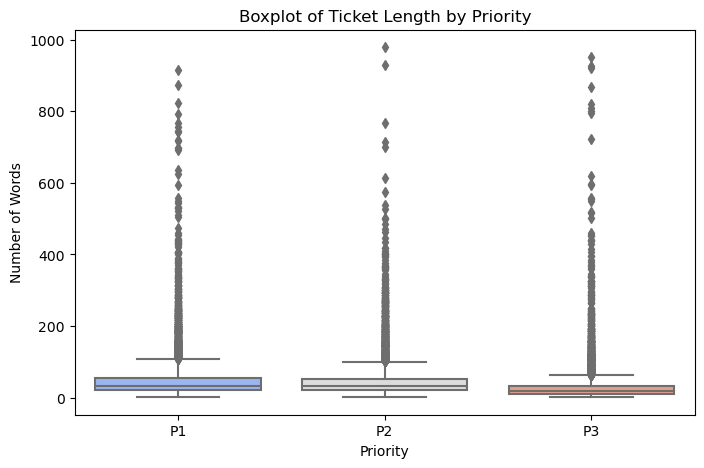

In [75]:
# Boxplot of Text Length by Priority
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Priority'], y=df['Text_Length'], palette='coolwarm')
plt.title("Boxplot of Ticket Length by Priority")
plt.xlabel("Priority")
plt.ylabel("Number of Words")
plt.show()

# Feature Engineering

In [76]:
df=df.drop("TicketID",axis=1)
df.sample(5)

,Description,Priority,Text_Length
5200,sent july issue hello trying enter for week ju...,P1,43
1677,access issues dear suddenly lost access follow...,P1,30
7347,sent friday failure danube hi device danube fa...,P1,43
13838,reopen status hi guys please add reopen status...,P3,14
10575,sent monday november log requests working safa...,P1,24


In [77]:
priority_mapping = {'P1': 0, 'P2': 1, 'P3': 2}
df['Priority'] = df['Priority'].map(priority_mapping)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Description'], df['Priority'], test_size=0.2, random_state=42, stratify=df['Priority'])

In [81]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Models

In [82]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Training & Evaluating Models



In [85]:
best_model = None
best_accuracy = 0
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

C:\Users\afrah khan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression
Accuracy: 0.7727272727272727
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70      1350
           1       0.63      0.51      0.56      1106
           2       0.97      1.00      0.99      1504

    accuracy                           0.77      3960
   macro avg       0.75      0.75      0.75      3960
weighted avg       0.77      0.77      0.77      3960


Model: Random Forest
Accuracy: 0.7707070707070707
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.85      0.72      1350
           1       0.67      0.37      0.48      1106
           2       0.98      1.00      0.99      1504

    accuracy                           0.77      3960
   macro avg       0.76      0.74      0.73      3960
weighted avg       0.77      0.77      0.75      3960


Model: Naive Bayes
Accuracy: 0.7462121212121212
Classification Report:
          

In [86]:
pickle.dump(best_model, open("best_support_ticket_model.pkl", "wb"))
pickle.dump(vectorizer, open("tfidf_vectorizer.pkl", "wb"))


Making Predictions

In [89]:
def predict_priority(ticket_text):
    """ Predicts the priority of a given support ticket."""
    cleaned_text = clean_text(ticket_text)  
    text_tfidf = vectorizer.transform([cleaned_text])  
    predicted_priority = best_model.predict(text_tfidf)  
    priority_label = {0: 'P1', 1: 'P2', 2: 'P3'}.get(predicted_priority[0])  
    return priority_label

new_ticket = "System is completely down, unable to process transactions."
print("Predicted Priority:", predict_priority(new_ticket))


Predicted Priority: P1
